In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

import numpy as np
import matplotlib.pyplot as plt
from tifffile import imread
import os
from tqdm import tqdm_notebook as tqdm
from keras import backend as K

from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.utils import plot_some
from csbdeep.data import RawData, create_patches
from csbdeep.io import load_training_data
from keras.models import load_model
from networks.layers import MaxPoolingWithArgmax2D, MaxUnpooling2D

Using TensorFlow backend.
c:\users\nuno martins\appdata\local\conda\conda\envs\tensorflow_gpuenv\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\nuno martins\appdata\local\conda\conda\envs\tensorflow_gpuenv\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\nuno martins\appdata\local\conda\conda\envs\tensorflow_gpuenv\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)

In [2]:
limit_gpu_memory(fraction=2/3)

## For reloading model from Segnet (with custom layers)

In [2]:
model = load_model('test_models/mynet.h5', custom_objects={'MaxPoolingWithArgmax2D': MaxPoolingWithArgmax2D, 'MaxUnpooling2D':MaxUnpooling2D})
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 64) 256         conv2d_1[0][0]                   
_______________________________________________________

### Step by step procedure of visualizing filters

In [4]:
layer_name = 'conv2d_1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [5]:
grads = K.gradients(loss, model.input)[0]
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [6]:
iterate = K.function([model.input], [loss, grads])

loss_value , grads_value = iterate([np.zeros((1, 128, 128, 1))])

In [7]:
input_img_data = np.random.random((1, 128, 128, 1))
# plt.figure()
# plt.imshow(input_img_data[0, :, :, 0])

step = 1.
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    
    input_img_data += grads_value*step

## Loop and functions to visualize filters
### Function to normalize image

In [3]:
def deprocess_image(temp_img):
    temp_img -= temp_img.mean()
    temp_img /= (temp_img.std() + 1e-5)
    temp_img *= 0.1 
    
    temp_img += 0.5
    temp_img = np.clip(temp_img, 0, 1)
    
    temp_img *= 255
    temp_img = np.clip(temp_img, 0, 255).astype('uint8')
    return temp_img


### Function to generate filter

In [4]:
def generate_pattern(layer_name, filter_index, size = 128):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    
    grads = K.gradients(loss, model.input)[0]
    
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    iterate = K.function([model.input], [loss, grads])
    
    input_img_data = np.random.random((1, size, size, 1)) * 20 + 128.
    
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value*step
        
    img = input_img_data[0]
    return deprocess_image(img)

In [ ]:
plt.imshow(generate_pattern('conv2d_26', 0)[:, :, 0])

## apply filters to real image

In [5]:
base_dir = '/Data/imagesXY/'
testImgDir = os.path.join(base_dir, 'testImages')
testLabDir = os.path.join(base_dir, 'testLabels')

In [6]:
imgList = os.listdir(testImgDir)
img_path = os.path.join(testImgDir, imgList[0])

labList = os.listdir(testLabDir)
lab_path = os.path.join(testLabDir, labList[0])

img = imread(img_path)
lab = imread(lab_path)

img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255
print('image tensor shape: ',img_tensor.shape)
print('image tensor max: ', np.max(img_tensor))

lab_tensor = image.img_to_array(lab)
lab_tensor = np.expand_dims(lab_tensor, axis=0)
lab_tensor /= 255
print('label tensor shape: ', lab_tensor.shape)
print('label tensor max: ', np.max(lab_tensor))

image tensor shape:  (1, 752, 752, 1)
image tensor max:  0.827451
label tensor shape:  (1, 752, 752, 1)
label tensor max:  0.68235296


In [ ]:
fig = plt.figure(figsize=(12,5))
imgplt = fig.add_subplot(1, 2, 1)
imgplt.imshow(img_tensor[0, ..., 0])
labplt = fig.add_subplot(1, 2, 2)
labplt.imshow(lab_tensor[0,...,0])

In [ ]:
px_coord = 1

x = img_tensor[:, px_coord*128:(px_coord+1)*128, px_coord*128:(px_coord+1)*128]
y = lab_tensor[:, px_coord*128:(px_coord+1)*128, px_coord*128:(px_coord+1)*128]
print(x.shape)
print(y.shape)

fig = plt.figure(figsize=(12,5))
raw = fig.add_subplot(1, 2, 1)
raw.imshow(x[0, ..., 0])
gt = fig.add_subplot(1, 2, 2)
gt.imshow(y[0, ..., 0])

In [9]:
def generate_pattern_on_image(layer_name, input_image, filter_index, size = 128):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    
    grads = K.gradients(loss, model.input)[0]
    
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    iterate = K.function([model.input], [loss, grads])
    
    input_img_data = input_image
    
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value*step
        
    img = input_img_data[0]
    return deprocess_image(img)

75 181


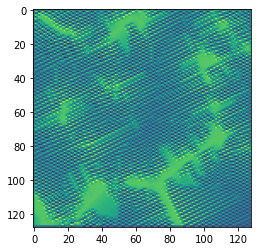

In [22]:
preview = generate_pattern_on_image('activation_1', x.copy(), 1, size=128)
plt.imshow(preview[..., 0])

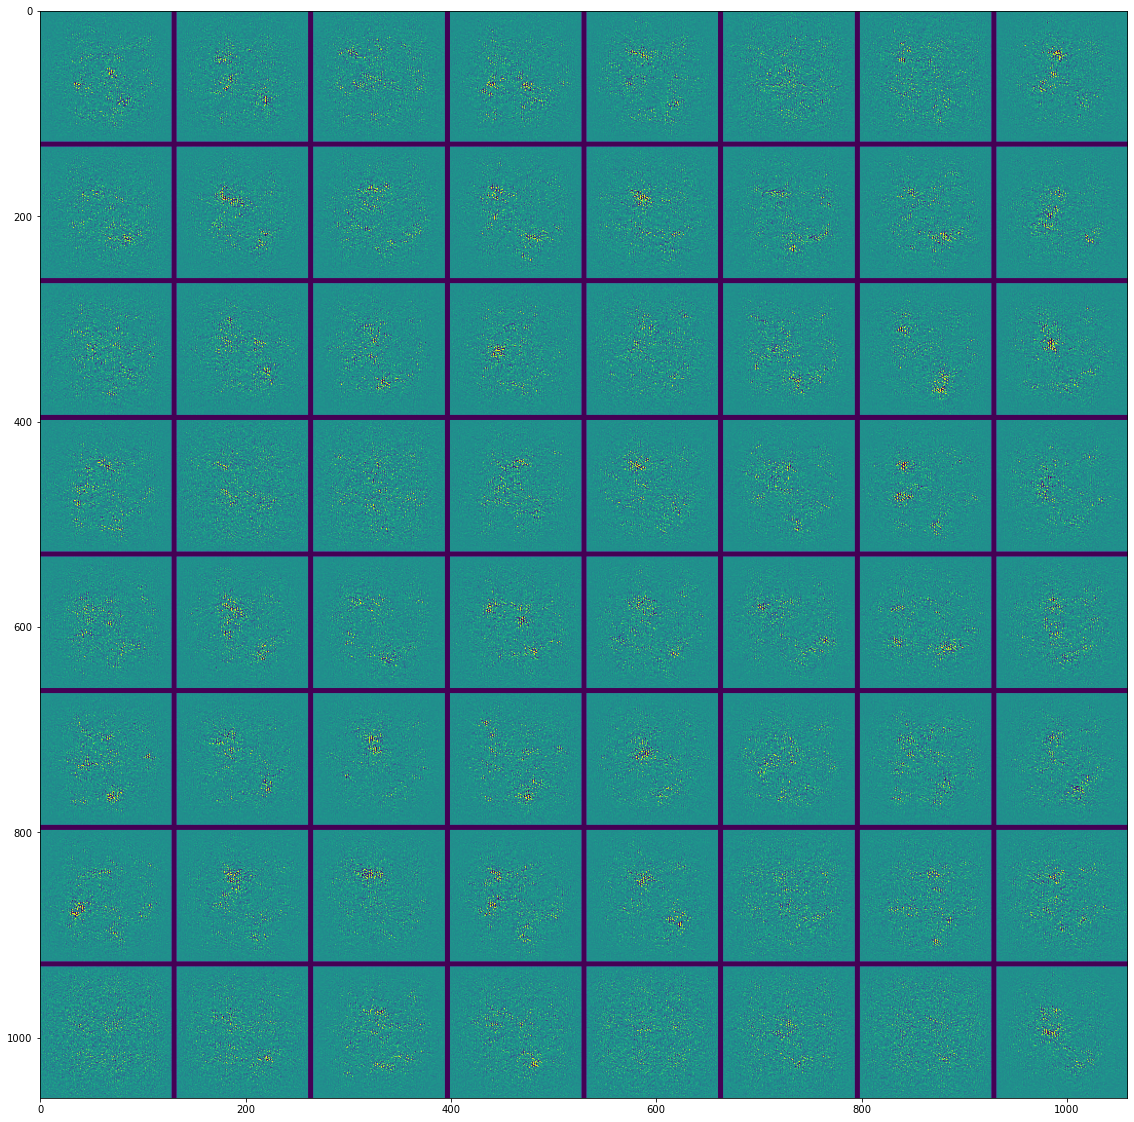

In [36]:
layer_name = 'activation_27'
size = 128
margin = 5
offset = 0 #to get more than the first 64 channels

results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 1))

for i in range(8):
    for j in range(8):
        filter_img = generate_pattern_on_image(layer_name, x.copy(), (i + (j * 8))+(64*offset), size=size)
        
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start+size
        results[horizontal_start : horizontal_end, vertical_start : vertical_end, :] = filter_img

plt.figure(figsize = (20, 20))
plt.imshow(results[..., 0])